In [1]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from helpers.cm26 import DatasetCM26
from helpers.selectors import select_NA, select_Pacific, select_Cem, select_globe, compare, plot, select_ACC, select_Equator
from helpers.operators import Coarsen, Filtering, Subsampling, CoarsenKochkov, CoarsenWeighted, CoarsenKochkovMinMax
from helpers.state_functions import *

import hvplot.xarray
import hvplot
import cmocean

%load_ext autoreload
%autoreload 3

# Reading data on Greene

In [66]:
def read_dataset(train_str='validate', factor=15):
    depth_selector = lambda x: x.isel(zl=np.arange(0,50,5))
    base_path = f'/scratch/pp2681/mom6/CM26_datasets/ocean3d/Gauss-FGR3/factor-{factor}'
    param = depth_selector(xr.open_dataset(f'{base_path}/param.nc'))

    nfiles = {'train': 96, 'test': 24, 'validate': 12}
    file_list = [f'{base_path}/{train_str}-{j}.nc' for j in range(nfiles[train_str])]
    data = xr.open_mfdataset(file_list, chunks={'zl':1, 'time':1}, concat_dim='time', combine='nested')
    return DatasetCM26(data, param)

In [72]:
ds = read_dataset(factor=4)

Text(0.5, 1.0, '0194-01-13 12:00:00, 3508.633056640625')

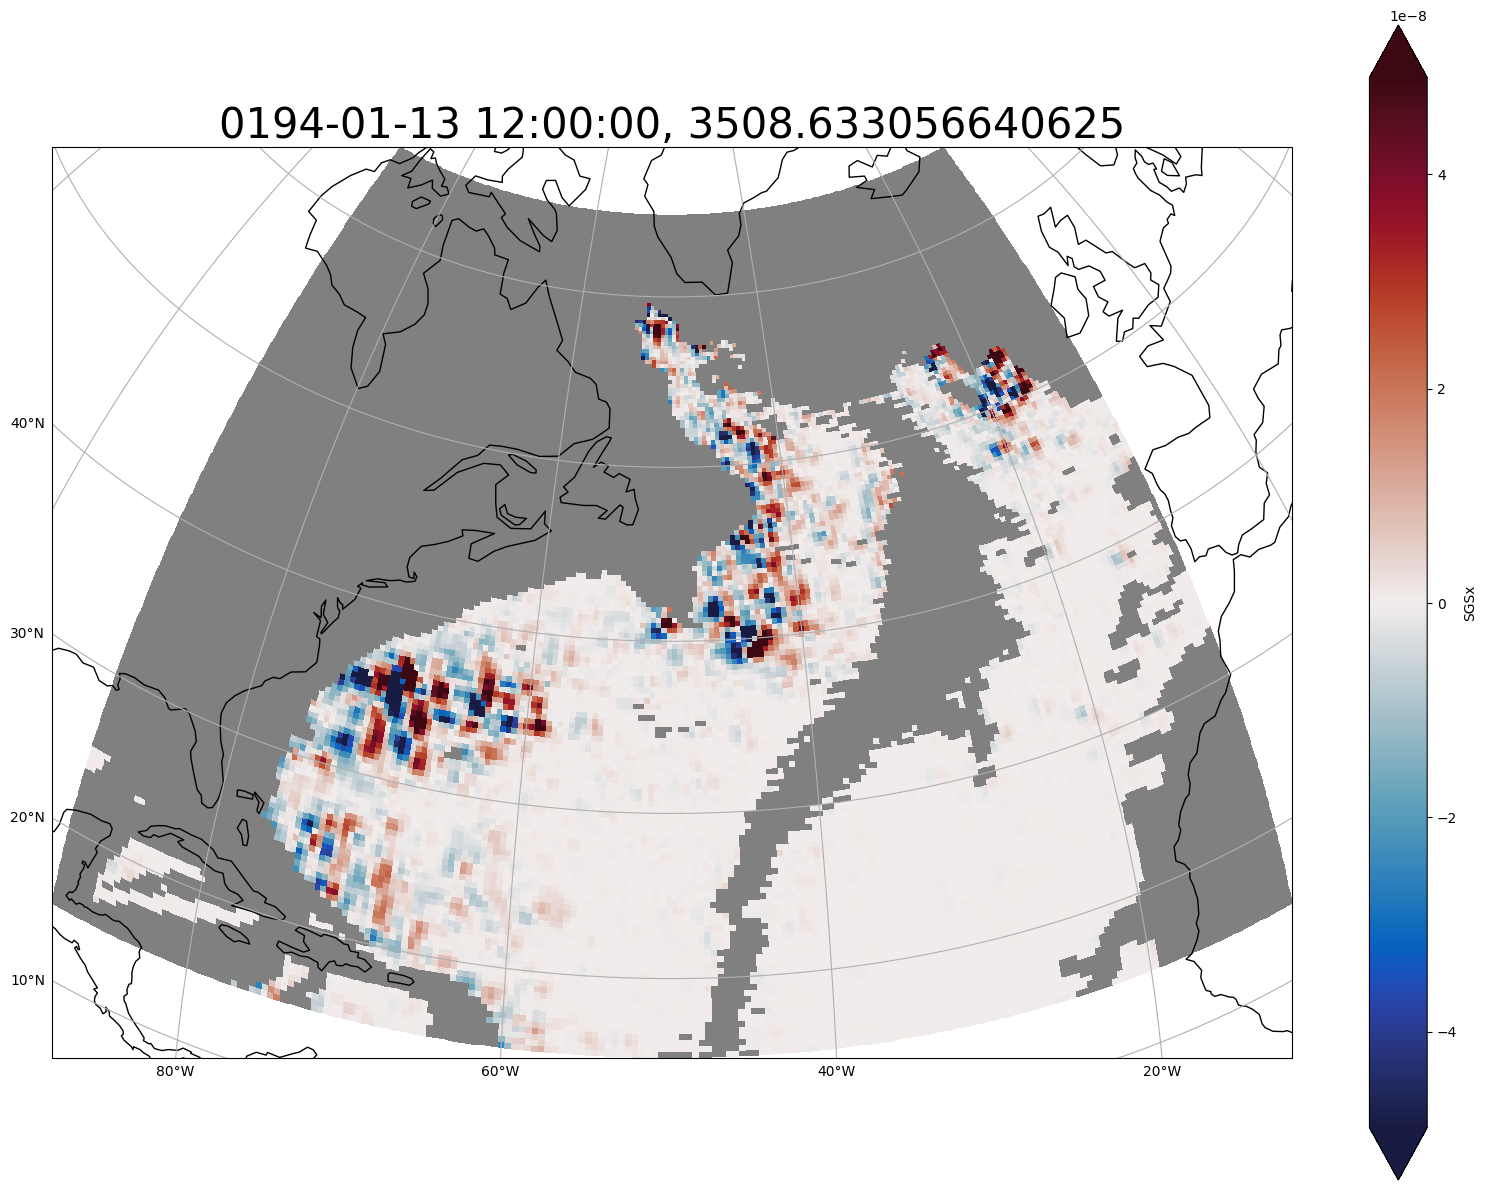

In [154]:
ds2d = ds.select2d(zl=8, time=0)
plot(ds2d.nanvar(ds2d.data.SGSx))
plt.title(f'{ds2d.data.time.values}, {ds2d.data.zl.values}', fontsize=30)

Correlation: 0.6934024225322433
Relative Error: 0.7286759613994569
R2 =  0.4614990367874712
R2 max =  0.48094988337620526
Optinal scaling: 0.8325678174491141
Nans [test/control]: [17666, 17666]


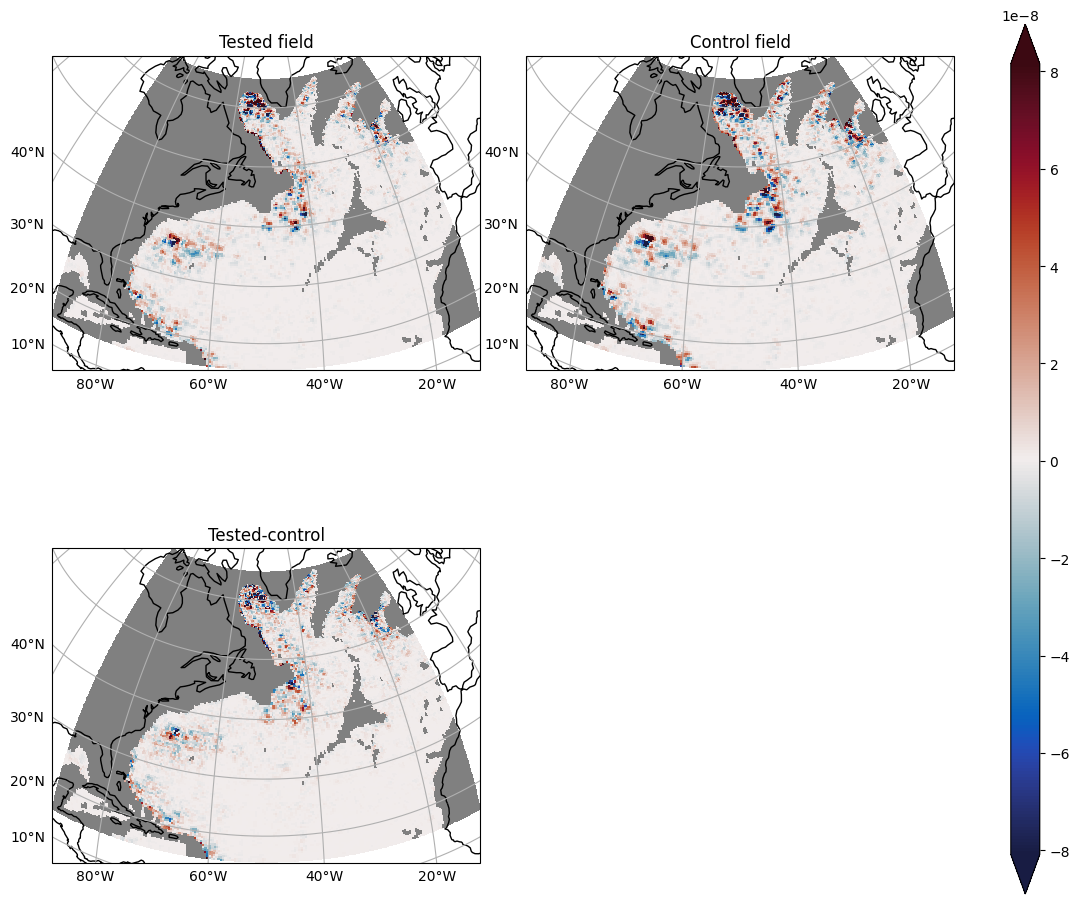

In [189]:
ds2d = ds.select2d(zl=7, time=0)
ann_Txy = import_ANN('/scratch/pp2681/mom6/CM26_ML_models/Gauss-FGR2/hdn-64-64-sym/model/Txy_epoch_2000.nc')
ann_Txx_Tyy = import_ANN('/scratch/pp2681/mom6/CM26_ML_models/Gauss-FGR2/hdn-64-64-sym/model/Txx_Tyy_epoch_2000.nc')
compare(ds2d.nanvar(ds2d.state.ANN(ann_Txy,ann_Txx_Tyy)['ZB20v']*1.35), ds2d.nanvar(ds2d.data.SGSy), selector=select_NA)

Correlation: 0.10406864956113876
Relative Error: 1.057129965005874
R2 =  -0.011639912315311252
R2 max =  0.011110407582304527
Optinal scaling: 0.4113594161935489
Nans [test/control]: [20764, 20764]


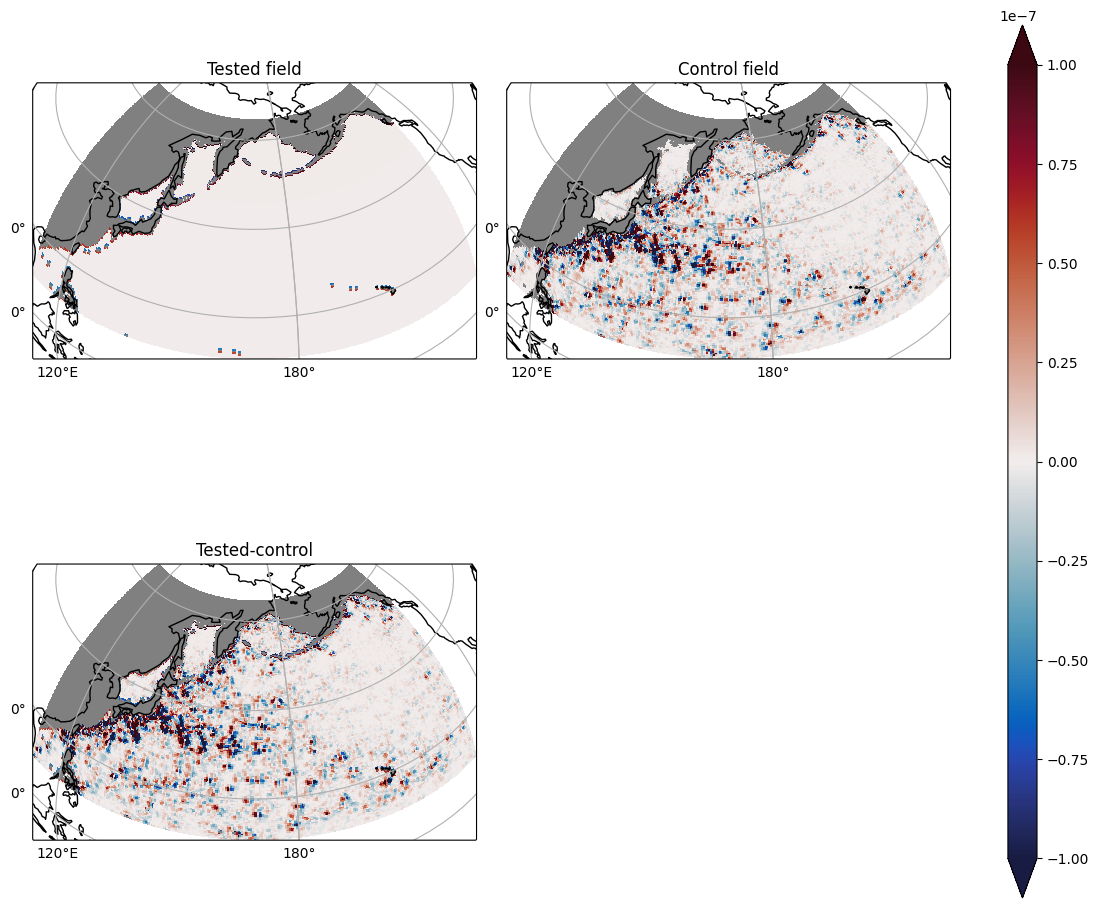

In [76]:
ds2d = ds.select2d(zl=3, time=0)
ann_Txy = import_ANN('/scratch/pp2681/mom6/CM26_ML_models/Gauss-FGR2/hdn-64-64/model/Txy_epoch_2000.nc')
ann_Txx_Tyy = import_ANN('/scratch/pp2681/mom6/CM26_ML_models/Gauss-FGR2/hdn-64-64/model/Txx_Tyy_epoch_2000.nc')
ann_Txy_sym = import_ANN('/scratch/pp2681/mom6/CM26_ML_models/Gauss-FGR2/hdn-64-64-sym/model/Txy_epoch_2000.nc')
ann_Txx_Tyy_sym = import_ANN('/scratch/pp2681/mom6/CM26_ML_models/Gauss-FGR2/hdn-64-64-sym/model/Txx_Tyy_epoch_2000.nc')
compare(ds2d.nanvar(ds2d.state.ANN(ann_Txy,ann_Txx_Tyy)['ZB20u']), ds2d.nanvar(ds2d.state.ANN(ann_Txy_sym,ann_Txx_Tyy_sym)['ZB20u']), 
        selector=select_Pacific, vmax = 10e-8, vmin=-10e-8)